# Analysis of experimentally measured beam loss

The beam loss at injection shall be compared to the theoretical expectation. 

Let $I_F$ be the intensity of the beam at time $T_F$ the end of INJECTION (beginning of PREPARE RAMP) and $\Delta I_i$ the intensity injected at the injection step $i$. The time of injection at the step $i$ is denoted as $T_i$. Assuming that all losses are caused by dynamic aperture, the final intensity is related to the injected intensity as 

$$ I_F = 2 \, \sum_{i=0}^N \, \Delta I_i \, \int_{D(T_F-T_i)}^{\infty} \rho(x) \, dx \, ,$$

where $\rho(x)$ is the transverse particle distribution, $D(T_F-T_i)$ is the dynamic aperture for the injected bunch at the end of INJECTION and $N$ is the number of injection steps. We are interested in relative losses, so we are going to compare the quantity

$$ r = \frac{\sum_i^N \Delta I_i - I_F}{\sum_i^N \Delta I_i} \, .$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytimber as pt
from __future__ import print_function

from sixdesk.da import davst, beamloss
from sixdesk.dist import dgauss

bl = beamloss('/home/phermes/development/mk_loss_da/Utilities/generate_beam_loss_from_da/dgauss_152samples/')
# plt.style.use('ggplot')

font = {'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)

## Initialize pytimber and specify the names for the required variables

In [2]:
db = pt.LoggingDB()

In [3]:
b1intensity = 'LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'
b2intensity = 'LHC.BCTDC.B6R4.B2:BEAM_INTENSITY'
lhc_energy  = 'LHC.BQSH.B1:ENERGY'
beam_mode   = 'LHC.CISG.CCR.A:BEAM_MODE'
chroma      = 'LHC.BOFSU:CHROMA_B1_H'
emit1x      = 'LHC.BQSH.B1:NORM_EMITTANCE_BSRT'
emit2x      = 'LHC.BQSH.B2:NORM_EMITTANCE_BSRT'
emit1v      = 'LHC.BQSV.B1:NORM_EMITTANCE_BSRT'
emit2v      = 'LHC.BQSV.B2:NORM_EMITTANCE_BSRT'

## Define basic functions for the loss analysis

In [4]:
def get_injection_phases(fill_number):
    '''Get the time stamps of the beginning and end of the injection phase for a given fill.'''
    data = db.getLHCFillData(fill_number)['beamModes']
    for j in data:
        if j['mode']=='INJPHYS':
            return j['startTime'], j['endTime']

In [5]:
def _get_raw_injection_times(dataset,thresh=0.005e14):    
    time_array, intensity_array = dataset
    indices = np.diff(intensity_array)>thresh
    indices = np.append(indices, False)
    return time_array[indices], intensity_array[indices]

def get_injection_times(dataset, thresh=0.005e14):
    '''Returns arrays with the times of injection of nominal bunches and the injected bunch intensity'''
    injection_times, injection_intensity = _get_raw_injection_times(dataset,thresh=thresh)
    
    steps_indices   = np.diff(injection_times)>2.      # use only steps which are more than 2 seconds apart from another
    steps_indices   = np.append(steps_indices, True)
    
    injection_intensity = injection_intensity[steps_indices]
    injection_times     = injection_times[steps_indices]
    return injection_times, injection_intensity

def get_delta_i(dataset):
    '''Create dataframe with injection timestamps, intensity before and the injected intensity.'''
    time_steps, intensity_steps    = get_injection_times(dataset)
    time_injection, data_injection = dataset
    output = []
    for n in range(len(time_steps)):
        int_before_step = data_injection[time_injection <= time_steps[n]+5]
        output.append([time_steps[n], intensity_steps[n], int_before_step[-1] - int_before_step[-10]])
    return pd.DataFrame(output,columns=['time','intensity_before_injection','injected_intensity'])

def get_experimental_beam_loss(dataset):
    '''Calculates the lost fraction of the bunch intensity from injection to start of ramp'''
    injected_beam = get_delta_i(dataset)
    times_to_eoi  = get_time_to_prepare_ramp(dataset)
    
    return (injected_beam['injected_intensity'].sum()-dataset[1][-1])/injected_beam['injected_intensity'].sum(), times_to_eoi

def get_time_to_prepare_ramp(dataset):
    return dataset[0][-1] - get_delta_i(dataset)['time']

def get_simulated_loss(data, fit_params, realizations):
    '''Calculates the beam loss as simulated by the model'''
    injected_beam = get_delta_i(data)
    times_to_eoi  = get_time_to_prepare_ramp(data)    
    
    total_intensity = (1 - bl.loss_from_fit_params(fit_params, 
                                                   time=times_to_eoi[0], 
                                                   realizations=realizations))*injected_beam['injected_intensity'][0]
    
    for j in range(1,len(times_to_eoi)):
        total_intensity = total_intensity + (1 - bl.loss_from_fit_params(fit_params, 
                                                                         time=times_to_eoi[j], 
                                                                         realizations=realizations))*injected_beam['injected_intensity'][j]
    return (sum(injected_beam['injected_intensity'])-total_intensity)/sum(injected_beam['injected_intensity'])

def get_loss_from_da(a, seconds):
    a.get_extrapolated_da(seconds=seconds,realizations=1)
    daseries = a.extrapolated_da['exda_{0}_sec'.format(seconds)]
    return bl.get_loss_from_da_series(daseries)

## Analyze the 2016 runs 
### Beam 1

Load the data for 2016 and calculate the observed beam loss between the first injection and the beginning of PREPARE RAMP. First initialize the dynamic aperture simulations and get the fit parameters for three different chromaticities. For the emittance we use the mean of the measured emittances at the end of injection. The database must be prepared accordingly using the unequal emittances option in the SixDeskDB. Further information can be found here:

https://github.com/SixTrack/SixDeskDB/pull/32

The command to calculate the DA vs turns in SixDeskDB would be:
    
    ./sixdb lhc_b1_inj_2016_qp_20_ioct_40_emit_2.00_1.66.db da_vs_turns -emit 2.0 1.66

In [6]:
emittance = None
doFit     = False    # set to True if the DA shall be fitted

dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_20_ioct_40_emit_2.00_1.66.db'
a1e = davst(dbname.format(20,40), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_18_ioct_40_emit_2.00_1.66.db'
b1e = davst(dbname.format(18,40), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2016_qp_16_ioct_40_emit_2.00_1.66.db'
c1e = davst(dbname.format(16,40), emittance)

if doFit:
    for database in [a1e,b1e,c1e]:
        database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1e.fit_params = a1e.fit_params.append(b1e.fit_params)
a1e.fit_params = a1e.fit_params.append(c1e.fit_params)
a1e.fit_params = a1e.fit_params.reset_index(drop=True)    

a1e.get_extrapolated_da(minutes=30, realizations=1)

### Check out the distribution of the extrapolated DA

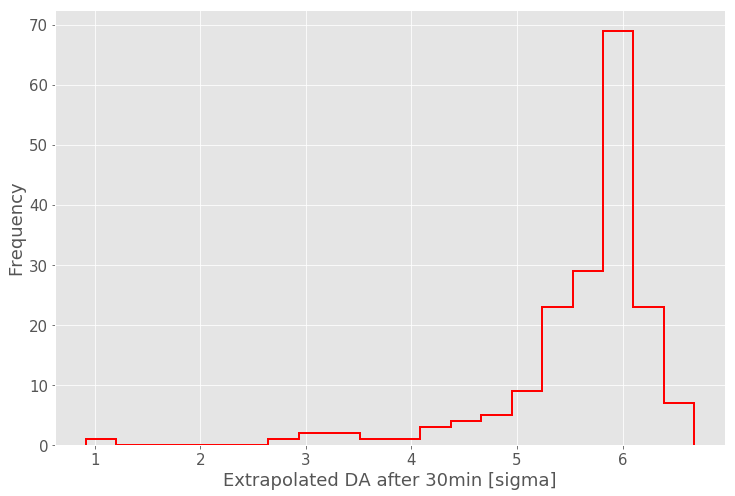

In [7]:
fig = plt.figure(figsize=(12,8))
plt.hist(a1e.extrapolated_da['exda_1800_sec'],bins=20, color='red',histtype='step',lw=2)
plt.xlabel("Extrapolated DA after 30min [sigma]")
plt.ylabel("Frequency")
plt.show()

In [6]:
import sqlite3

Get a list of all fill numbers in 2016 in stable proton beams

In [7]:
fills  = pd.read_csv('fills_2016.csv',
                     usecols=[0],
                     names=['fill'],
                     skiprows=1)

fills  = np.array(fills['fill'])

## Calculate the measured beam loss

In this model, the sum of the injected bunch intensities at the moment of injection is compared to the total beam intensity at the start of ramp. More detailed data could be gathered by looking at the bunch-by-bunch intensity.

In [8]:
def get_measured_and_simulated_loss(beam_int, fills, davst_obj):
    '''Calculates the measured and simulated bunch by bunch losses '''
    
    simulated_loss = np.array([])    # array to store the simulated beam loss values 
    output         = []              # array to store the measured beam loss and time from injection to ramp
    
    for i, fill in enumerate(fills):
        try:
            start, end   = get_injection_phases(fill)                 # get the start/end times of the INJ beam mode
            data         = db.get([beam_int],start,end)               # get the beam intensity between t_start and t_end
            experimental, times = get_experimental_beam_loss(data[beam_int]) # get the measured beam loss
            length       = end - start                                # duration of the fill
            
            print('{0}/{1} Fill number: {2}'.format(i,len(fills),fill), end='\r')
            
            if (experimental>0) & (experimental<0.05):
                for t in times:
                    loss_this_fill = get_loss_from_da(davst_obj, int(t))
                    simulated_loss = np.append(simulated_loss, loss_this_fill) 

                    output.append([fill, experimental, np.mean(loss_this_fill),length])
        except IndexError:
            pass
            
    output = pd.DataFrame(output,columns=['fill','experimental','simulated_mean','duration'])
    return output, simulated_loss
            
        

In [10]:
output_b1, simulated_loss_b1 = get_measured_and_simulated_loss(b1intensity, fills, a1e)

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  


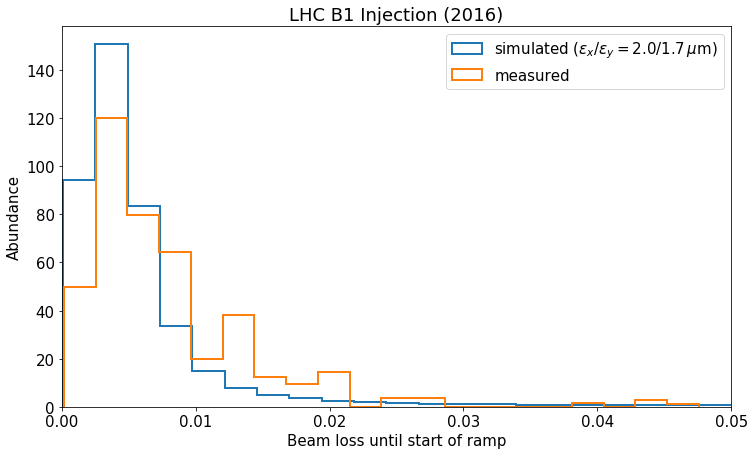

In [13]:
fig = plt.figure(figsize=[12,7])
plt.hist(simulated_loss_b1,bins=390,normed=True,histtype='step',
         label=r'simulated ($\epsilon_x/\epsilon_y = 2.0 / 1.7 \, \mu$m)',lw=2)
plt.hist(output_b1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)

plt.title(r'LHC B1 Injection (2016)')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.savefig("LHCB1_loss_16.pdf",bbox_inches='tight')
plt.show()

## Beam 2

In [9]:
emittance = None
doFit     = False

dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
a2e = davst(dbname.format(1.76,1.39), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
b2e = davst(dbname.format(1.76,1.39), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2016_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
c2e = davst(dbname.format(1.76,1.39), emittance)

if doFit:
    for database in [a2e,b2e,c2e]:
        database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a2e.fit_params = a2e.fit_params.append(b2e.fit_params)
a2e.fit_params = a2e.fit_params.append(c2e.fit_params)
a2e.fit_params = a2e.fit_params.reset_index(drop=True)    

a2e.get_extrapolated_da(minutes=30)

In [10]:
output_b2, simulated_loss_b2 = get_measured_and_simulated_loss(b2intensity, fills, a2e)

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  


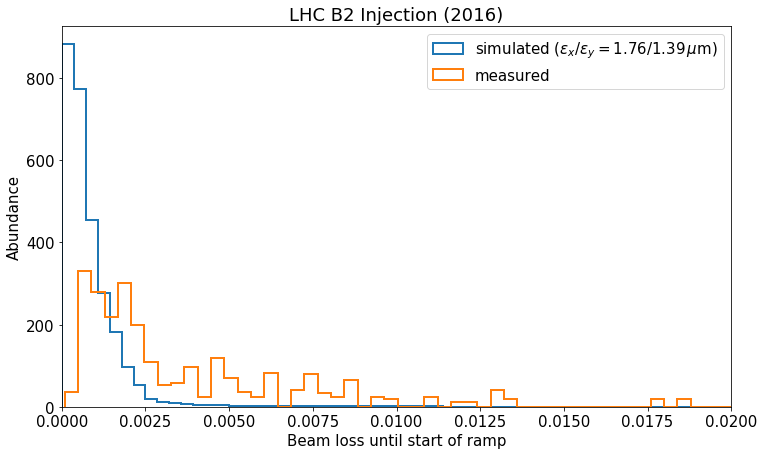

In [15]:
fig = plt.figure(figsize=[12,7])
plt.hist(simulated_loss_b2,bins=110,normed=True,histtype='step',label=r'simulated ($\epsilon_x/\epsilon_y = 1.76/1.39 \, \mu$m)',lw=2)
plt.hist(output_b2['experimental'],normed=True,histtype='step',bins=100, label='measured',lw=2)

plt.title(r'LHC B2 Injection (2016)')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.02)
plt.savefig("LHCB2_loss_16.pdf",bbox_inches='tight')
plt.show()

# ATS 2017

In 2017, the filling scheme was changed and two different sets of data must be used. The mean emittance for fills before 6270 was 1.83/1.77um (B1). For fills after 6270 it was 1.12/1.10um.

In [11]:
df = pd.read_csv('fills_2017.csv')
fills  = df['Fill Number']
fills1 = fills[fills<6270]
fills2 = fills[fills>6270]
len(fills), len(fills1), len(fills2)

(235, 163, 72)

In [17]:
emittance = None
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
a1 = davst(dbname.format(1.83,1.77), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
b1 = davst(dbname.format(1.83,1.77), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
c1 = davst(dbname.format(1.83,1.77), emittance)

# for database in [a1s,b1s,c1s]:
#     database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)    

a1.get_extrapolated_da(minutes=30)

In [18]:
output_b1, simulated_loss_b1 = get_measured_and_simulated_loss(b1intensity, fills1, a1)

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  


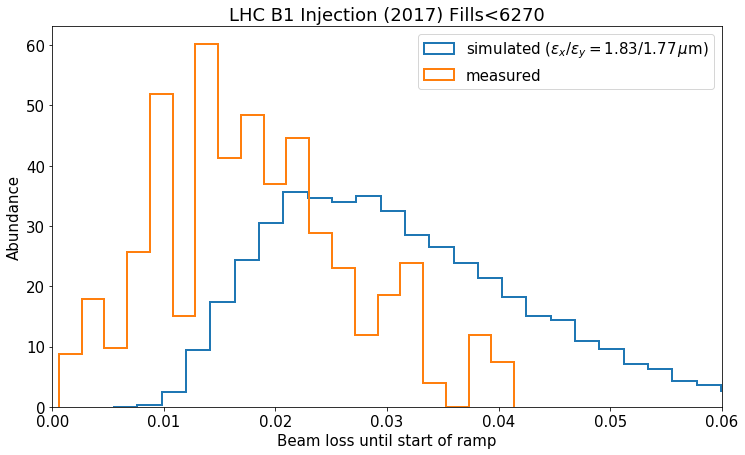

In [26]:
fig = plt.figure(figsize=[12,7])
plt.hist(simulated_loss_b1,bins=50,normed=True,histtype='step',label=r'simulated ($\epsilon_x/\epsilon_y = 1.83/1.77 \, \mu$m)',lw=2)
plt.hist(output_b1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)

plt.title(r'LHC B1 Injection (2017) Fills<6270')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.06)
plt.savefig("LHCB1_loss_17_1.pdf")
plt.show()

In [29]:
emittance = None
ex,ey = 1.12, 1.10
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
a1 = davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
b1 = davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b1_inj_2017_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
c1 = davst(dbname.format(ex, ey), emittance)

# for database in [a1,b1,c1]:
#     database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)    

a1.get_extrapolated_da(minutes=30)

In [30]:
output_b1, simulated_loss_b1 = get_measured_and_simulated_loss(b1intensity, fills2, a1)

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  


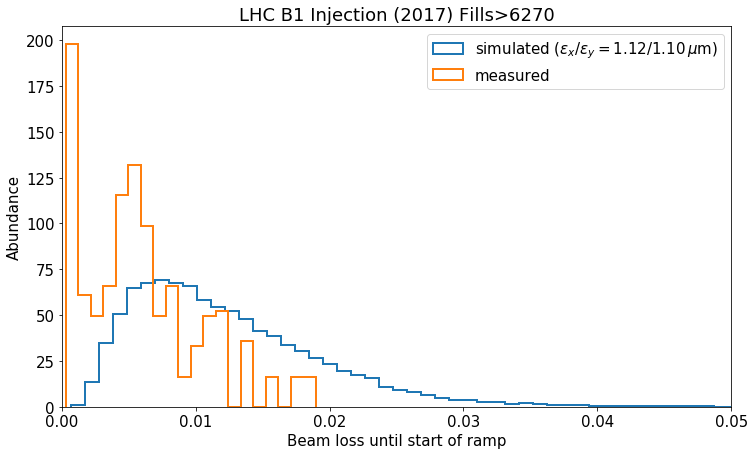

In [37]:
fig = plt.figure(figsize=[12,7])
plt.hist(simulated_loss_b1,bins=59,normed=True,histtype='step',label=r'simulated ($\epsilon_x/\epsilon_y = 1.12/1.10 \, \mu$m)',lw=2)
plt.hist(output_b1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)

plt.title(r'LHC B1 Injection (2017) Fills>6270')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.savefig("LHCB1_loss_17_2.pdf")

plt.show()

## Beam 2

#### Fill< 6270

In [12]:
emittance = None
ex,ey = 1.87, 1.77
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
a1 = davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
b1 = davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
c1 = davst(dbname.format(ex, ey), emittance)

# for database in [a1,b1,c1]:
#     database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)    

a1.get_extrapolated_da(minutes=30)

In [13]:
output_b2, simulated_loss_b2 = get_measured_and_simulated_loss(b2intensity, fills1, a1)

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  


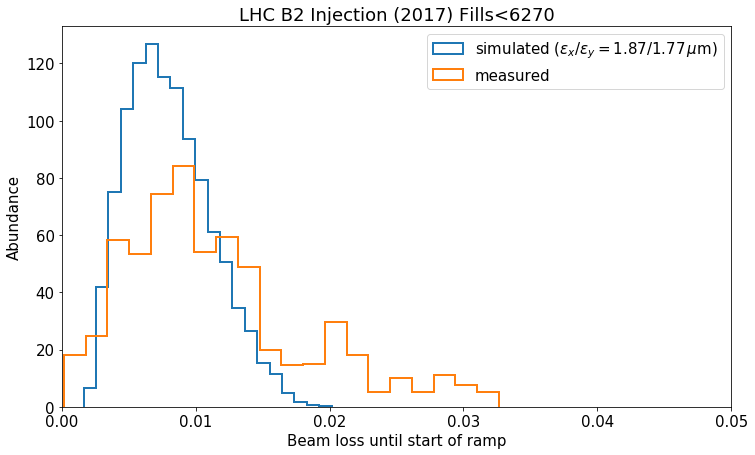

In [15]:
fig = plt.figure(figsize=[12,7])
plt.hist(simulated_loss_b2,bins=20,normed=True,histtype='step',label=r'simulated ($\epsilon_x/\epsilon_y = 1.87/1.77 \, \mu$m)',lw=2)
plt.hist(output_b2['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)

plt.title(r'LHC B2 Injection (2017) Fills<6270')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.savefig("LHCB2_loss_17_1.pdf")

plt.show()

#### Fill>6270

In [16]:
emittance = None
ex,ey = 1.15, 1.08
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_20_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
a1 = davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_18_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
b1 = davst(dbname.format(ex, ey), emittance)
dbname = '/media/phermes/local/unequal_emittances/lhc_b2_inj_2017_qp_16_ioct_40_emit_{0:4.2f}_{1:4.2f}.db'
c1 = davst(dbname.format(ex, ey), emittance)

# for database in [a1,b1,c1]:
#     database.fit(save=True,dacol='dastrap', daerrcol='dastraperrepang')
    
a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)    

a1.get_extrapolated_da(minutes=30)

In [17]:
output_b2, simulated_loss_b2 = get_measured_and_simulated_loss(b2intensity, fills2, a1)

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  


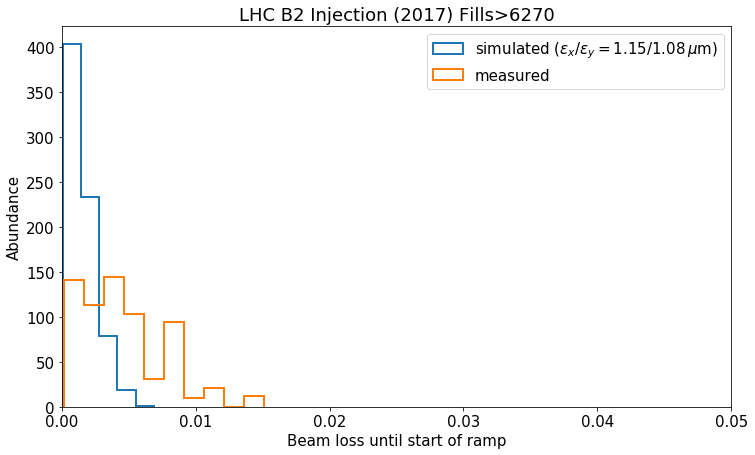

In [21]:
fig = plt.figure(figsize=[12,7])
plt.hist(simulated_loss_b2,bins=5,normed=True,histtype='step',label=r'simulated ($\epsilon_x/\epsilon_y = 1.15/1.08 \, \mu$m)',lw=2)
plt.hist(output_b2['experimental'],normed=True,histtype='step',bins=10, label='measured',lw=2)

plt.title(r'LHC B2 Injection (2017) Fills>6270')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.savefig("LHCB2_loss_17_2.pdf")

plt.show()